1.View the version of GPU and cuda

In [1]:
#view cuda和GPU

import torch
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print(f"Current device: {torch.cuda.get_device_name(device)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("Current device not support CUDA")

#set font
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"


Current device: NVIDIA GeForce RTX 4050 Laptop GPU
CUDA version: 11.5


2.Distribution of pKa and Molecular weight

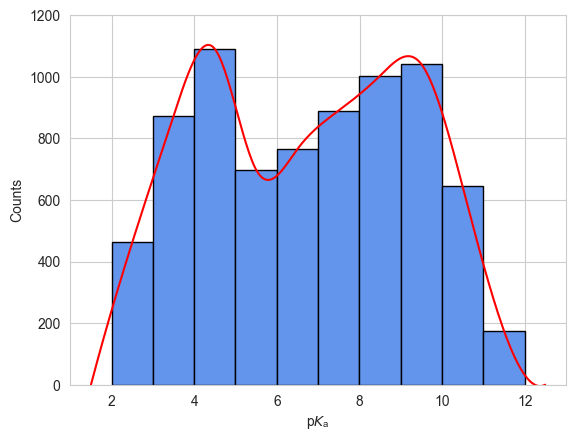

In [2]:
#pKa 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
import seaborn as sns

df = pd.read_csv('data/finetuning/finetune_7642.csv')
sns.set_style('whitegrid')
pKa_data = df['pKa']
counts, bin_edges, _ = plt.hist(pKa_data, bins=10, edgecolor='black', color='cornflowerblue')
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
extended_bin_centers = np.concatenate(([2 * bin_centers[0] - bin_centers[1]], bin_centers, [2 * bin_centers[-1] - bin_centers[-2]]))
extended_counts = np.concatenate(([0], counts, [0]))
x_new = np.linspace(extended_bin_centers.min(), extended_bin_centers.max(), 300)
spl = make_interp_spline(extended_bin_centers, np.maximum(extended_counts, 0), k=3)  
y_smooth = spl(x_new)
plt.plot(x_new, y_smooth, color='red')


plt.xlim(1, 13)
plt.ylim(0,1200)  
plt.xlabel('p$K$ₐ')
plt.ylabel('Counts')
plt.show()

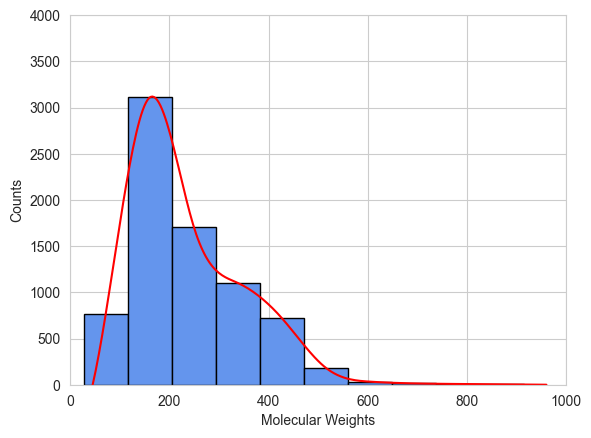

In [3]:
#Molecular weight
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors

df = pd.read_csv('data/finetuning/finetune_7642.csv')

smiles_data = df['smiles']

def calculate_molecular_weight(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is not None:
        return Descriptors.ExactMolWt(molecule)
    else:
        return None

df['molecular_weight'] = smiles_data.apply(calculate_molecular_weight)
df = df.dropna(subset=['molecular_weight'])
plt.hist(df['molecular_weight'], bins=10, edgecolor='black', color='cornflowerblue')

counts, bin_edges = np.histogram(df['molecular_weight'], bins=10)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

extended_bin_centers = np.concatenate(([2 * bin_centers[0] - bin_centers[1]], bin_centers, [2 * bin_centers[-1] - bin_centers[-2]]))
extended_counts = np.concatenate(([0], counts, [0]))

x_new = np.linspace(extended_bin_centers.min(), extended_bin_centers.max(), 300)
spl = make_interp_spline(extended_bin_centers, extended_counts, k=3)
y_smooth = spl(x_new)
plt.plot(x_new, y_smooth, color='red')


plt.xlim(0, 1000)
plt.ylim(0, 4000)
plt.xlabel('Molecular Weights')
plt.ylabel('Counts')
plt.show()

3.Tanimoto Coefficient

Mean Tanimoto Coefficient: 0.07922453090681232


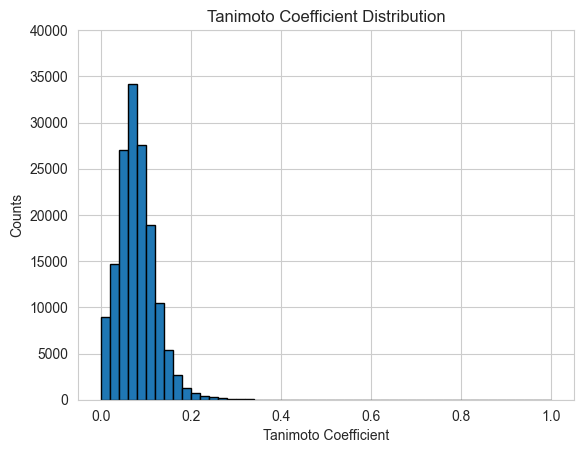

In [4]:
from rdkit import DataStructs
import pandas as pd
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem

# test set
df1 = pd.read_csv("data/test/SAMPL7.csv")
smiles_list1 = df1['smiles'].tolist()

# training set
df2 = pd.read_csv("data/finetuning/finetune_7642.csv")
smiles_list2 = df2['smiles'].tolist()

# SMILES to mol
mols1 = [Chem.MolFromSmiles(smi) for smi in smiles_list1]
mols2 = [Chem.MolFromSmiles(smi) for smi in smiles_list2]

# calculate FP
fps1 = [AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=4096) for mol in mols1]
fps2 = [AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=4096) for mol in mols2]

# calculate Tanimoto_coefficients
tanimoto_coefficients = []
for fp1 in fps1:
    for fp2 in fps2:
        coefficient = DataStructs.TanimotoSimilarity(fp1, fp2)
        tanimoto_coefficients.append(coefficient)

mean_coefficient = np.mean(tanimoto_coefficients)
print("Mean Tanimoto Coefficient:", mean_coefficient)


plt.ylim(0, 40000)
plt.hist(tanimoto_coefficients, bins=50, range=(0, 1), edgecolor='black')
plt.xlabel('Tanimoto Coefficient')
plt.ylabel('Counts')
plt.title('Tanimoto Coefficient Distribution')
plt.show()

5.Performance on internal test set

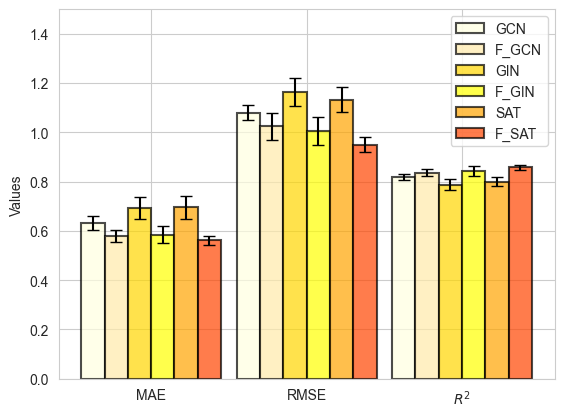

In [5]:
#valid
import matplotlib.pyplot as plt
import numpy as np

means1 = [0.633, 1.080, 0.818]
means2 = [0.580, 1.024, 0.836]
means3 = [0.693, 1.163, 0.788]
means4 = [0.584, 1.004, 0.843]
means5 = [0.695, 1.132, 0.799]
means6 = [0.561, 0.950, 0.858]


stds1 = [0.029, 0.029, 0.011]
stds2 = [0.024, 0.055, 0.015]
stds3 = [0.046, 0.057, 0.023]
stds4 = [0.034, 0.056, 0.019]
stds5 = [0.046, 0.051, 0.018]
stds6 = [0.018, 0.030, 0.010]

# label
labels = ['MAE', 'RMSE', '$R^2$']


x_pos = np.arange(len(labels))
width = 0.15
fig, ax = plt.subplots()

# set color
colors =  ['#FFFFE0', '#FFEAAA','gold', 'yellow',  'orange','orangered']

rects1 = ax.bar(x_pos - 0.375, means1, yerr=stds1, align='center', alpha=0.7, capsize=4,width=width, color=colors[0], edgecolor='black',linewidth=1.5,label='GCN')
rects2 = ax.bar(x_pos - 0.225, means2, yerr=stds2, align='center', alpha=0.7, capsize=4,width=width, color=colors[1], edgecolor='black',linewidth=1.5,label='F_GCN')
rects3 = ax.bar(x_pos - 0.075, means3, yerr=stds3, align='center', alpha=0.7,capsize=4, width=width, color=colors[2],edgecolor='black',linewidth=1.5, label='GIN')
rects4 = ax.bar(x_pos + 0.075, means4, yerr=stds4, align='center', alpha=0.7, capsize=4,width=width, color=colors[3],edgecolor='black',linewidth=1.5, label='F_GIN')
rects5 = ax.bar(x_pos + 0.225, means5, yerr=stds5, align='center', alpha=0.7,capsize=4, width=width, color=colors[4],edgecolor='black',linewidth=1.5, label='SAT')
rects6 = ax.bar(x_pos + 0.375, means6, yerr=stds6, align='center', alpha=0.7, capsize=4,width=width, color=colors[5],edgecolor='black',linewidth=1.5, label='F_SAT')

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)

ax.legend()
plt.ylim(0, 1.5)
ax.set_ylabel('Values')
plt.show()

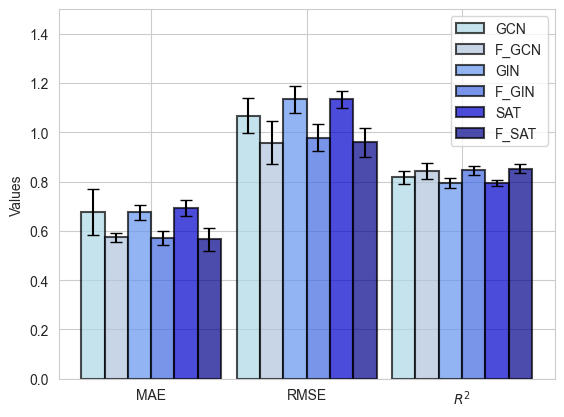

In [6]:
#test
import matplotlib.pyplot as plt
import numpy as np


means1 = [0.677,1.067,0.817]
means2 = [0.573,0.958,0.843]
means3 = [0.675,1.134,0.794]
means4 = [0.572,0.978,0.846]
means5 = [0.692,1.134,0.794]
means6 = [0.565,0.959,0.852]

stds1 = [0.093,0.071,0.025]
stds2 = [0.019,0.086,0.031]
stds3 = [0.029,0.055,0.019]
stds4 = [0.028,0.054,0.019]
stds5 = [0.033,0.034,0.013]
stds6 = [0.045,0.060,0.019]

# label
labels = ['MAE', 'RMSE', '$R^2$']


x_pos = np.arange(len(labels))
width = 0.15
fig, ax = plt.subplots()

# set color
colors =  ['lightblue', 'lightsteelblue', 'cornflowerblue', 'royalblue', 'mediumblue', 'darkblue']

rects1 = ax.bar(x_pos - 0.375, means1, yerr=stds1, align='center', alpha=0.7, capsize=4,width=width, color=colors[0], edgecolor='black',linewidth=1.5,label='GCN')
rects2 = ax.bar(x_pos - 0.225, means2, yerr=stds2, align='center', alpha=0.7, capsize=4,width=width, color=colors[1], edgecolor='black',linewidth=1.5,label='F_GCN')
rects3 = ax.bar(x_pos - 0.075, means3, yerr=stds3, align='center', alpha=0.7,capsize=4, width=width, color=colors[2],edgecolor='black',linewidth=1.5, label='GIN')
rects4 = ax.bar(x_pos + 0.075, means4, yerr=stds4, align='center', alpha=0.7, capsize=4,width=width, color=colors[3],edgecolor='black',linewidth=1.5, label='F_GIN')
rects5 = ax.bar(x_pos + 0.225, means5, yerr=stds5, align='center', alpha=0.7,capsize=4, width=width, color=colors[4],edgecolor='black',linewidth=1.5, label='SAT')
rects6 = ax.bar(x_pos + 0.375, means6, yerr=stds6, align='center', alpha=0.7, capsize=4,width=width, color=colors[5],edgecolor='black',linewidth=1.5, label='F_SAT')

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylabel('Values')
plt.ylim(0, 1.5)
plt.show()

6.Robustness of model

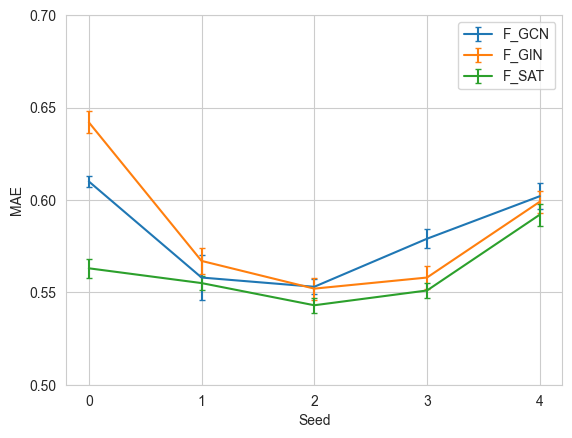

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# model name
models = ['F_GCN', 'F_GIN', 'F_SAT']

# means
mean_data = [
    [0.610, 0.558, 0.553, 0.579, 0.602],
    [0.642, 0.567, 0.552, 0.558, 0.599],
    [0.563, 0.555, 0.543, 0.551, 0.592]]

# stds
std_data = [
    [0.003, 0.012, 0.004, 0.005, 0.007],
    [0.006, 0.007, 0.006, 0.006, 0.006],
    [0.005, 0.004, 0.004, 0.004, 0.006]]

x = np.arange(5)
fig, ax = plt.subplots()

for i in range(len(models)):
    ax.errorbar(x, mean_data[i], yerr=std_data[i], label=models[i], capsize=2)

ax.set_ylim([0.5, 0.7])
ax.yaxis.set_ticks(np.arange(0.5, 0.7 + 0.05, 0.05))
ax.set_xlabel('Seed')
ax.set_ylabel('MAE')
ax.set_xticks(x)
ax.legend()
plt.show()

7.Performance on external test set

123
Extracting 3-hop subgraphs...
Done!
Test RMSE: 0.725, Test MAE: 0.473, Test R2: 0.905
Max MAE SMILES: N#Cc1ccc([C@H]2[C@H]3C(O)N(Cc4ccc(F)cc4)C(=O)[C@H]3[C@@H]3CC(F)(F)CN32)cc1


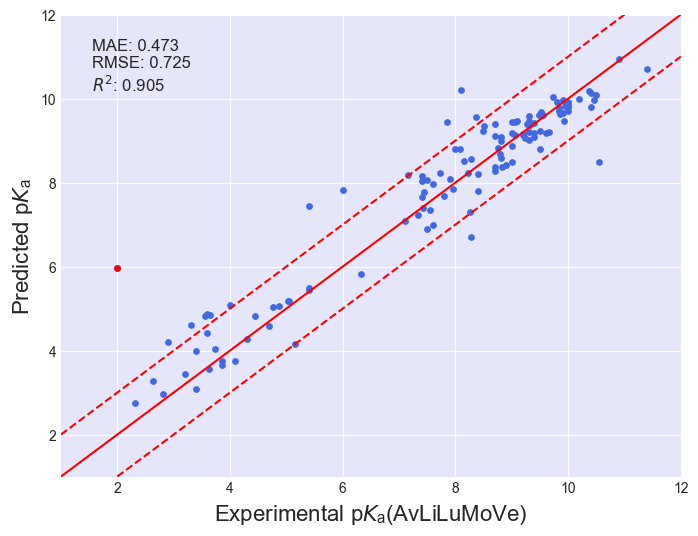

In [7]:
import numpy as np
import yaml
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from descriptor import MolTestDataset
from models.sat_finetune import GraphTransformer,GraphDataset
import pandas as pd

batch_size = 512
device = 'cuda' if torch.cuda.is_available() else 'cpu'
test_dataset = MolTestDataset('data/test/AvLiLuMoVe_123.csv','pKa')
test_dataset = GraphDataset(test_dataset,degree=True, k_hop=3,se = "khopgnn",use_subgraph_edge_attr=True)

# load best model
config = yaml.load(open("config_finetune.yaml", "r"), Loader=yaml.FullLoader)
best_model = GraphTransformer(**config["sat"])
best_model.to(device)
best_model.load_state_dict(torch.load("data/model_weight/SAT/Finetune_SAT.pth"))
best_model.eval()

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

test_pka = []
test_pred = []

# tensor(6.7641) tensor(2.5215) torch.Size([7642, 1])

means = 6.7641
stds = 2.5215

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        data.y=(data.y-means)/stds

        output = best_model(data)

        output = output*stds+means
        data.y=data.y*stds+means

        test_pka.extend(data.y.detach().cpu().numpy())
        test_pred.extend(output.detach().cpu().numpy())

test_pka = np.array(test_pka).flatten()
test_pred = np.array(test_pred).flatten()
mse = mean_squared_error(test_pka, test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_pka, test_pred)
r2 = r2_score(test_pka, test_pred)
print(f"Test RMSE: {rmse:.3f}, Test MAE: {mae:.3f}, Test R2: {r2:.3f}")

#show outliers
max_mae_index = np.argmax(np.abs(test_pka - test_pred))
max_mae_smiles = data.smiles[max_mae_index]

print(f"Max MAE SMILES: {max_mae_smiles}")


fig, ax = plt.subplots(figsize=(8,6))
ax.grid(color='white')
ax.scatter(test_pka, test_pred, c='royalblue', s=15)  
ax.scatter(test_pka[max_mae_index], test_pred[max_mae_index], c='red', s=15)
ax.set_facecolor('lavender')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)

# add title and label
ax.set_xlabel('Experimental p$K$ₐ(AvLiLuMoVe)', fontsize=16)
ax.set_ylabel('Predicted p$K$ₐ', fontsize=16)

ax.text(0.05, 0.95, "MAE: {:.3f}\nRMSE: {:.3f}\n$R^2$: {:.3f}".format(mae, rmse, r2), fontsize=12, transform=ax.transAxes, verticalalignment='top')
ax.set_xlim(1, 12)
ax.set_ylim(1, 12)
ax.set_axisbelow(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))
ax.plot([1, 12], [1, 12], linestyle='-', color='red')
ax.plot([1, 11], [2, 12], linestyle='--', color='red')  
ax.plot([2, 12], [1, 11], linestyle='--', color='red') 

plt.show()